In [56]:
from pathlib import Path
import pandas as pd
import numpy as np
import re, json
import re

Daily: shape=(2106, 13)
      datum  M01AB  M01AE  N02BA  N02BE  N05B  N05C   R03  R06  Year  Month  \
0  1/2/2014    0.0   3.67    3.4  32.40   7.0   0.0   0.0  2.0  2014      1   
1  1/3/2014    8.0   4.00    4.4  50.60  16.0   0.0  20.0  4.0  2014      1   
2  1/4/2014    2.0   1.00    6.5  61.85  10.0   0.0   9.0  1.0  2014      1   

   Hour Weekday Name  
0   248     Thursday  
1   276       Friday  
2   276     Saturday   

Hourly: shape=(50532, 13)
            datum  M01AB  M01AE  N02BA  N02BE  N05B  N05C  R03  R06  Year  \
0   1/2/2014 8:00    0.0   0.67    0.4    2.0   0.0   0.0  0.0  1.0  2014   
1   1/2/2014 9:00    0.0   0.00    1.0    0.0   2.0   0.0  0.0  0.0  2014   
2  1/2/2014 10:00    0.0   0.00    0.0    3.0   2.0   0.0  0.0  0.0  2014   

   Month  Hour Weekday Name  
0      1     8     Thursday  
1      1     9     Thursday  
2      1    10     Thursday   

Weekly: shape=(302, 9)
       datum  M01AB  M01AE  N02BA   N02BE  N05B  N05C   R03   R06
0   1/5/2014  14.00

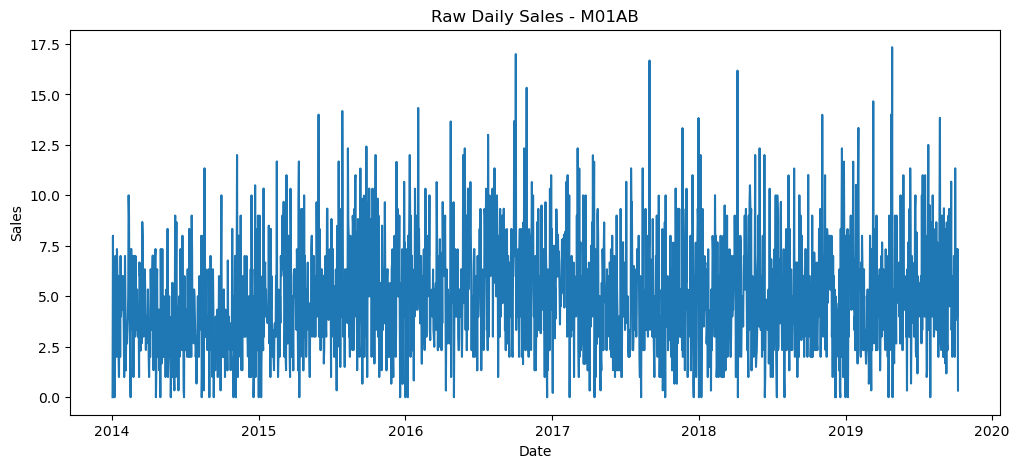

In [42]:
### EDA

RAW_DIR = Path("/Users/monicaekstein/Downloads/ADS505 Pharma Sales Data")

daily_raw = pd.read_csv(RAW_DIR / "salesdaily.csv")
hourly_raw = pd.read_csv(RAW_DIR / "saleshourly.csv")
weekly_raw = pd.read_csv(RAW_DIR / "salesweekly.csv")
monthly_raw = pd.read_csv(RAW_DIR / "salesmonthly.csv")

for name, df in {
    "Daily": daily_raw, "Hourly": hourly_raw,
    "Weekly": weekly_raw, "Monthly": monthly_raw
}.items():
    print(f"{name}: shape={df.shape}")
    print(df.head(3), "\n")

# Inspect missing values
daily_raw.isna().sum()

# Inspect duplicates
duplicates = daily_raw.duplicated().sum()
print("Duplicate rows:", duplicates)

# Check for negative or nonsensical values
numeric_cols = daily_raw.select_dtypes(include="number").columns
print("Negative values per column:")
print((daily_raw[numeric_cols] < 0).sum())

# Checl time coverage
pd.to_datetime(daily_raw["datum"], errors="coerce").agg(["min","max"])

# Spot-check distributions
daily_raw[numeric_cols].describe().T

import matplotlib.pyplot as plt

# plot one ATC category (example: M01AB)
plt.figure(figsize=(12,5))
plt.plot(pd.to_datetime(daily_raw["datum"]), daily_raw["M01AB"])
plt.title("Raw Daily Sales - M01AB")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


=== Daily ===
shape: (2106, 13)
missing (top 12):
 datum    0
M01AB    0
M01AE    0
N02BA    0
N02BE    0
N05B     0
N05C     0
R03      0
R06      0
Year     0
Month    0
Hour     0
dtype: int64
duplicate rows: 0

=== Hourly ===
shape: (50532, 13)
missing (top 12):
 datum    0
M01AB    0
M01AE    0
N02BA    0
N02BE    0
N05B     0
N05C     0
R03      0
R06      0
Year     0
Month    0
Hour     0
dtype: int64
duplicate rows: 0

=== Weekly ===
shape: (302, 9)
missing (top 12):
 datum    0
M01AB    0
M01AE    0
N02BA    0
N02BE    0
N05B     0
N05C     0
R03      0
R06      0
dtype: int64
duplicate rows: 0

=== Monthly ===
shape: (70, 9)
missing (top 12):
 datum    0
M01AB    0
M01AE    0
N02BA    0
N02BE    0
N05B     0
N05C     0
R03      0
R06      0
dtype: int64
duplicate rows: 0

Daily: 2014-01-02 00:00:00 → 2019-10-08 00:00:00 | expected freq=D | unique timestamps=2,106 | grid length=2,106 | completeness=1.000
most common gaps:
 datum
1 days    2105
Name: count, dtype: int64

Hour

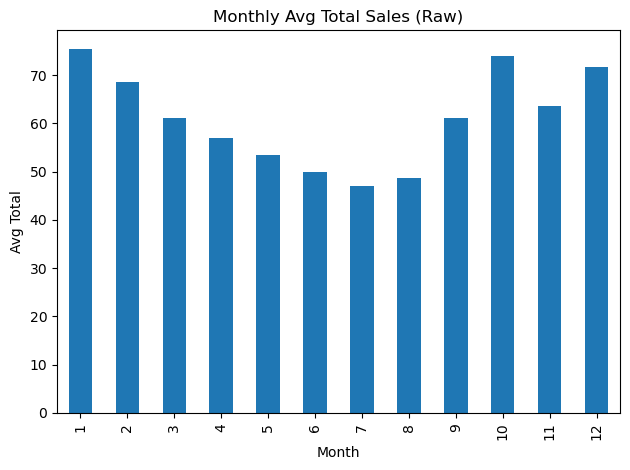

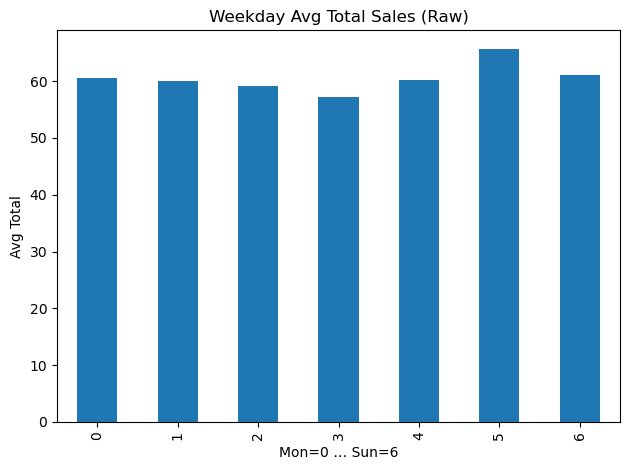


Top category totals:
 N02BE    63005.402708
N05B     18645.737500
R03      11608.822917
M01AB    10600.937083
M01AE     8204.618646
N02BA     8172.209000
R06       6107.817500
N05C      1249.958333
dtype: float64

Most volatile categories (CV):
 N05C     1.841528
R03      1.166261
R06      0.832983
N05B     0.633142
N02BA    0.614366
M01AE    0.547595
M01AB    0.543852
N02BE    0.521139
dtype: float64


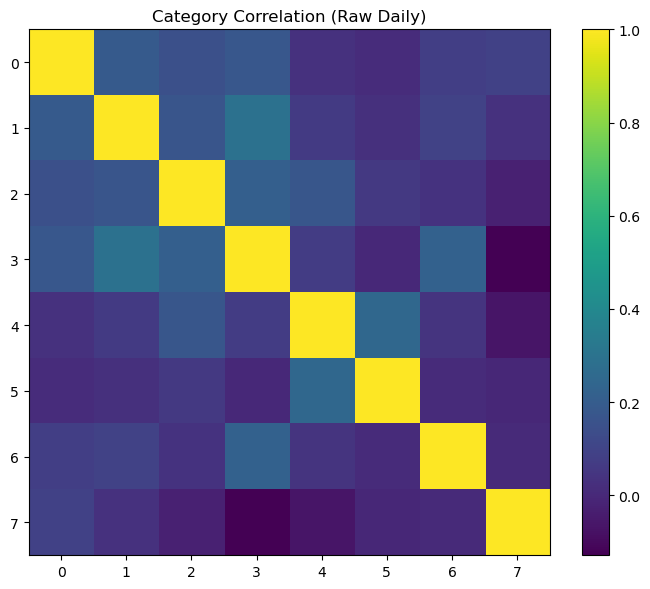


Outliers for M01AB (|z|>3), top 8:
           datum  M01AB
1941 2019-04-27  17.34
1004 2016-10-02  17.00
1337 2017-08-31  16.68
1556 2018-04-07  16.18
1031 2016-10-29  15.33
1894 2019-03-11  14.66
761  2016-02-02  14.33
572  2015-07-28  14.18


In [49]:
# Missingness and duplicates
def missing_and_dupes(df, name):
    print(f"\n=== {name} ===")
    print("shape:", df.shape)
    print("missing (top 12):\n", df.isna().sum().sort_values(ascending=False).head(12))
    print("duplicate rows:", df.duplicated().sum())

daily_raw  = pd.read_csv(RAW_DIR/"salesdaily.csv")
hourly_raw = pd.read_csv(RAW_DIR/"saleshourly.csv")
weekly_raw = pd.read_csv(RAW_DIR/"salesweekly.csv")
monthly_raw= pd.read_csv(RAW_DIR/"salesmonthly.csv")

for nm, df in [("Daily",daily_raw),("Hourly",hourly_raw),("Weekly",weekly_raw),("Monthly",monthly_raw)]:
    missing_and_dupes(df, nm)

# Gaps in time coverage
def time_completeness(df, name, freq_hint):
    dt = find_dt_col(df); s = pd.to_datetime(df[dt], errors="coerce").dropna().sort_values()
    full = pd.date_range(s.min(), s.max(), freq=freq_hint)
    # if there can be multiple rows per timestamp (wide format), count unique timestamps
    uniq = s.nunique()
    completeness = uniq/len(full)
    print(f"\n{name}: {s.min()} → {s.max()} | expected freq={freq_hint} | "
          f"unique timestamps={uniq:,} | grid length={len(full):,} | completeness={completeness:.3f}")
    print("most common gaps:\n", s.diff().value_counts().head(8))

time_completeness(daily_raw,  "Daily",  "D")
time_completeness(hourly_raw, "Hourly", "h")
time_completeness(weekly_raw, "Weekly", "W-MON")
time_completeness(monthly_raw,"Monthly","MS")

# Daily seasonality and category totals
dt = find_dt_col(daily_raw)
daily = daily_raw.copy()
daily[dt] = pd.to_datetime(daily[dt], errors="coerce")
cats = numeric_categories(daily, dt)

# Monthly & weekday patterns on totals across categories
tot = daily[cats].sum(axis=1)
daily["_month"]   = daily[dt].dt.month
daily["_weekday"] = daily[dt].dt.weekday

monthly_avg  = daily.groupby("_month")[cats].sum().sum(axis=1) / daily["_month"].value_counts().sort_index()
weekday_avg  = daily.groupby("_weekday")[cats].sum().sum(axis=1) / daily["_weekday"].value_counts().sort_index()

monthly_avg.plot(kind="bar", title="Monthly Avg Total Sales (Raw)")
plt.xlabel("Month"); plt.ylabel("Avg Total"); plt.tight_layout(); plt.show()

weekday_avg.plot(kind="bar", title="Weekday Avg Total Sales (Raw)")
plt.xlabel("Mon=0 … Sun=6"); plt.ylabel("Avg Total"); plt.tight_layout(); plt.show()

# Category totals & volatility (coefficient of variation)
totals = daily[cats].sum().sort_values(ascending=False)
cv = (daily[cats].std() / daily[cats].mean()).sort_values(ascending=False)
print("\nTop category totals:\n", totals.head(10))
print("\nMost volatile categories (CV):\n", cv.head(10))

# Correlation between categories
corr = daily[cats].corr()
plt.figure(figsize=(7,6))
plt.imshow(corr, aspect="auto")
plt.title("Category Correlation (Raw Daily)")
plt.colorbar(); plt.tight_layout(); plt.show()

# Outliers
sample = "M01AB" if "M01AB" in daily.columns else cats[0]
ser = pd.to_numeric(daily[sample], errors="coerce")
z = (ser - ser.mean())/ser.std()
out = daily.loc[z.abs()>3, [dt, sample]].sort_values(sample, ascending=False)
print(f"\nOutliers for {sample} (|z|>3), top 8:\n", out.head(8))

In [50]:
RAW_DIR = Path("/Users/monicaekstein/Downloads/ADS505 Pharma Sales Data").expanduser().resolve()

print(f"Data folder exists? {RAW_DIR.exists()}  →  {RAW_DIR}")

# Show
for p in sorted(RAW_DIR.iterdir()):
    print(" -", p.name)

expected = ["saleshourly.csv","salesdaily.csv","salesweekly.csv","salesmonthly.csv"]

# Case-insensitive map of filenames
present = {p.name.lower(): p for p in RAW_DIR.iterdir() if p.is_file()}

heads = {}
missing = []
for name in expected:
    p = present.get(name.lower())
    if p is None:
        missing.append(name)
        continue
    df = pd.read_csv(p, nrows=5)
    heads[name] = {
        "path": str(p),
        "columns": list(df.columns),
        "preview": df.head(3).to_dict(orient="records")
    }

print("\nLoaded keys:", list(heads.keys()))
if missing:
    print("Missing (check spelling/case):", missing)

if "saleshourly.csv" in heads:
    print("\nHourly columns:", heads["saleshourly.csv"]["columns"])
    print("Hourly preview:", heads["saleshourly.csv"]["preview"])

Data folder exists? True  →  /Users/monicaekstein/Downloads/ADS505 Pharma Sales Data
 - cleaned
 - salesdaily.csv
 - saleshourly.csv
 - salesmonthly.csv
 - salesweekly.csv

Loaded keys: ['saleshourly.csv', 'salesdaily.csv', 'salesweekly.csv', 'salesmonthly.csv']

Hourly columns: ['datum', 'M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06', 'Year', 'Month', 'Hour', 'Weekday Name']
Hourly preview: [{'datum': '1/2/2014 8:00', 'M01AB': 0, 'M01AE': 0.67, 'N02BA': 0.4, 'N02BE': 2, 'N05B': 0, 'N05C': 0, 'R03': 0, 'R06': 1, 'Year': 2014, 'Month': 1, 'Hour': 8, 'Weekday Name': 'Thursday'}, {'datum': '1/2/2014 9:00', 'M01AB': 0, 'M01AE': 0.0, 'N02BA': 1.0, 'N02BE': 0, 'N05B': 2, 'N05C': 0, 'R03': 0, 'R06': 0, 'Year': 2014, 'Month': 1, 'Hour': 9, 'Weekday Name': 'Thursday'}, {'datum': '1/2/2014 10:00', 'M01AB': 0, 'M01AE': 0.0, 'N02BA': 0.0, 'N02BE': 3, 'N05B': 2, 'N05C': 0, 'R03': 0, 'R06': 0, 'Year': 2014, 'Month': 1, 'Hour': 10, 'Weekday Name': 'Thursday'}]


In [29]:
RAW_DIR = Path("/Users/monicaekstein/Downloads/ADS505 Pharma Sales Data").expanduser().resolve()
OUT_DIR = RAW_DIR / "cleaned"
OUT_DIR.mkdir(parents=True, exist_ok=True)

FREQ_MAP = {
    "saleshourly.csv": "h",      # was "H"
    "salesdaily.csv": "D",
    "salesweekly.csv": "W-MON",
    "salesmonthly.csv": "MS",
}

def to_snake(name: str) -> str:
    name = re.sub(r"[^\w]+", "_", name.strip().lower())
    return re.sub(r"_+", "_", name).strip("_")

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    return df.rename(columns={c: to_snake(c) for c in df.columns})

def find_datetime_col(df: pd.DataFrame) -> str:
    # Common names first ('datum')
    candidates = ["datum", "date", "datetime", "timestamp", "time", "period_start", "period"]
    for cand in candidates:
        if cand in df.columns:
            return cand
        for c in df.columns:
            if c.startswith(cand) or cand in c:
                return c
    # Fallback: try to parse columns that look like dates
    for c in df.columns:
        try:
            parsed = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
            if parsed.notna().mean() > 0.9:
                return c
        except Exception:
            pass
    raise ValueError("No datetime-like column found.")

def coerce_datetime(df: pd.DataFrame, dt_col: str) -> pd.DataFrame:
    # errors→NaT rows aredropped
    df[dt_col] = pd.to_datetime(df[dt_col], errors="coerce")
    return df.dropna(subset=[dt_col]).copy()

TIME_AUX = {"year","month","hour","weekday","weekday_name","day","week"}

def identify_value_columns(df: pd.DataFrame, dt_col: str):
    # Treat all numeric columns except obvious time auxiliaries as sales series (ATC codes)
    candidates = [c for c in df.columns if c not in {dt_col} | TIME_AUX]
    numeric = [c for c in candidates if pd.api.types.is_numeric_dtype(df[c])]
    if not numeric:
        raise ValueError("No numeric value columns detected to melt.")
    return numeric

def normalize_categories(s: pd.Series) -> pd.Series:
    return (s.astype(str).str.strip().str.replace(r"\s+", " ", regex=True).str.upper())

def wide_to_long(df: pd.DataFrame, dt_col: str, value_cols):
    long_df = df.melt(id_vars=[dt_col], value_vars=value_cols,
                      var_name="category", value_name="value")
    long_df["category"] = normalize_categories(long_df["category"])
    return long_df

def remove_duplicates(df: pd.DataFrame, dt_col: str):
    before = len(df)
    df = df.drop_duplicates(subset=[dt_col, "category"], keep="last").copy()
    return df, before - len(df)

def drop_negative(df: pd.DataFrame):
    mask = pd.to_numeric(df["value"], errors="coerce") < 0
    dropped = int(mask.sum())
    return df.loc[~mask].copy(), dropped

def complete_index(df: pd.DataFrame, dt_col: str, freq: str) -> pd.DataFrame:
    # Reindex per category to ensure a complete time grid
    out = []
    for cat, sub in df.groupby("category", sort=False):
        sub = sub.sort_values(dt_col)
        rng = pd.date_range(sub[dt_col].min(), sub[dt_col].max(), freq=freq)
        sub = sub.set_index(dt_col).reindex(rng)
        sub.index.name = dt_col
        sub["category"] = cat
        out.append(sub.reset_index())
    return pd.concat(out, ignore_index=True)

def impute_timeseries(df: pd.DataFrame, dt_col: str) -> pd.DataFrame:
    def _impute(g):
        g = g.sort_values(dt_col).copy()
        g["value"] = pd.to_numeric(g["value"], errors="coerce")
        g["value"] = g["value"].ffill().bfill().fillna(0.0)
        return g

    # Select only the columns the function needs
    cols = [dt_col, "category", "value"]
    return df[cols].groupby("category", group_keys=False).apply(_impute)

def quality_report(df: pd.DataFrame, name: str, dt_col: str, ddupes: int, dneg: int):
    rep = {
        "dataset": name,
        "rows": int(len(df)),
        "time_min": str(df[dt_col].min()),
        "time_max": str(df[dt_col].max()),
        "n_categories": int(df["category"].nunique()),
        "dupes_removed": ddupes,
        "negatives_removed": dneg,
        "null_counts": df.isna().sum().to_dict(),
        "value_stats": df["value"].describe().to_dict(),
    }
    (OUT_DIR / f"{Path(name).stem}_quality_report.json").write_text(json.dumps(rep, indent=2))
    return rep

def save_csv(df: pd.DataFrame, name: str):
    out = OUT_DIR / f"{Path(name).stem}_cleaned.csv"
    df.to_csv(out, index=False)
    dd = {
        "dataset": name,
        "columns": [{"name": c, "dtype": str(t)} for c, t in df.dtypes.items()]
    }
    (OUT_DIR / f"{Path(name).stem}_data_dictionary.json").write_text(json.dumps(dd, indent=2))
    return out

def clean_one(filename: str) -> dict:
    path = RAW_DIR / filename
    if not path.exists():
        raise FileNotFoundError(path)
    raw = pd.read_csv(path)
    raw = standardize_columns(raw)

    dt_col = find_datetime_col(raw)
    raw = coerce_datetime(raw, dt_col)

    value_cols = identify_value_columns(raw, dt_col)
    long_df = wide_to_long(raw, dt_col, value_cols)

    long_df, ddupes = remove_duplicates(long_df, dt_col)
    long_df, dneg   = drop_negative(long_df)

    full = complete_index(long_df, dt_col, FREQ_MAP[filename])
    full = impute_timeseries(full, dt_col)
    full = full.rename(columns={dt_col: "datetime"}).sort_values(["category","datetime"]).reset_index(drop=True)

    rep = quality_report(full, filename, "datetime", ddupes, dneg)
    out_csv = save_csv(full, filename)

    print(f"✓ {filename}: {full.shape[0]:,} rows, {full['category'].nunique()} categories → {out_csv.name}")
    return {"file": filename, "rows": int(full.shape[0]), "categories": int(full["category"].nunique()), "csv": str(out_csv)}

summary = []
for fname in ["saleshourly.csv","salesdaily.csv","salesweekly.csv","salesmonthly.csv"]:
    if (RAW_DIR / fname).exists():
        summary.append(clean_one(fname))

pd.DataFrame(summary)

/var/folders/0p/ftllfwnx6jl6w7xyv2r4qxfw0000gn/T/ipykernel_33776/1179840179.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df[cols].groupby("category", group_keys=False).apply(_impute)


✓ saleshourly.csv: 404,256 rows, 8 categories → saleshourly_cleaned.csv
✓ salesdaily.csv: 16,848 rows, 8 categories → salesdaily_cleaned.csv
✓ salesweekly.csv: 2,408 rows, 8 categories → salesweekly_cleaned.csv
✓ salesmonthly.csv: 552 rows, 8 categories → salesmonthly_cleaned.csv


/var/folders/0p/ftllfwnx6jl6w7xyv2r4qxfw0000gn/T/ipykernel_33776/1179840179.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df[cols].groupby("category", group_keys=False).apply(_impute)
/var/folders/0p/ftllfwnx6jl6w7xyv2r4qxfw0000gn/T/ipykernel_33776/1179840179.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df[cols].groupby("category", group_keys=False).apply(_impute)
/var/folders/0

,file,rows,categories,csv
0,saleshourly.csv,404256,8,/Users/monicaekstein/Downloads/ADS505 Pharma S...
1,salesdaily.csv,16848,8,/Users/monicaekstein/Downloads/ADS505 Pharma S...
2,salesweekly.csv,2408,8,/Users/monicaekstein/Downloads/ADS505 Pharma S...
3,salesmonthly.csv,552,8,/Users/monicaekstein/Downloads/ADS505 Pharma S...


In [7]:
import os, pathlib, time
print("CWD:", os.getcwd())
p = pathlib.Path("ADS505_pharma_sales_forecasting.ipynb")
print("Exists here:", p.exists())
if p.exists():
    print("Absolute path:", p.resolve())
    print("Modified:", time.ctime(p.stat().st_mtime))

CWD: /Users/monicaekstein/Projects/ADS-505-Final-Project-Pharma-Sales-Forecast
Exists here: False
